# An Inquistion of NLP for Mining Functional Genomic Data for Transcription Factor Binding Sites. 
## $Omar Kana^{12}$ and $Sudin Bhattacharya^{123}$
1. Pharmacology and Toxicology Department Michigan State University, East Lansing, MI
2. Institute for Integrative Toxicology Michigan State University, East Lansing, MI
3. Biomedical Engineering Department Michigan State University, East Lansing, MI
 

A recent boon in natural language processing and sequence learning has lead to embeddings of words that reflect their meaning. Biological sequences share several properties with natural language data, and thus has lead to the question of the effectiveness of the NLP paradigm in creating functional embeddings of DNA. While DNA embeddings have been explored for genome alignment and motif analysis, there has yet to be an in depth reveiew looking at the effectiveness of different NLP techniques in embedding DNA transcription factor binding site prediction. This review will look at three differing advanced DNA embeddings: dna2vec (Ng et. al 2017), fastDNA (Menegaux et. al 2018), and EDNA (A model I hope to develop) which are variations of word2vec, fastText, and ELMo respectively. All of them will benchmarked against simple DNA embeddings and NLP techniques such as one-hot and tf-idf. These will be used to build binary classification models and then regression type models. Eventually, if we see potential in this paradigm, we would like to explore the possibility to genome imputation or annotation using document or topic based semantic analysis. 

It should be noted that DNA is not a natural language and as such, there should not be the expectation that there will be a 1 to 1 agreement with the models that work well in NLP. DNA is a continous string, yes, but the concept of delimited words beyond the nucleotides that make up the code. Here we will define words as overlapping k-mers of a fixed k or as a bag of overlapping k-mers of variable length k. However another problem arises when determining k. For our analysis, reads that are mapped for chip-seq is often defined at greater than or equal to 25 bps. While the there is a somewhat positive monotonic relationship between the k length, and embedding dimension and performance displayed in Whalen et. al 2016 and agian in Menegaux et. al 2018, the k-mer frequency vectors become incredible sparse as the likelyhood of that k-mer appearing in the sequence decreases exponentially. Also at larger k's, the space of possible sequences becomes significantly large ($4^n$). So will keep the k-mers here at below 15 and treat the sequece for each point on the bigwig file as a whole sentence. These sentences will be used for regression and classification.

Cytochrome P450 (CYP450) Genes are the primary players in xenobiotic metabolism in the liver. Due to CYP450 enzymes' promiscous nature, they are also incredibly prone to adverse reactions in xenobiotics. The precise genomic framework by which these genes are regulated has yet to be fully explored, and work to study these regulators and there DNA binding is often expensive and time consuming. Current motif search techniques often come with very high type I error. With the advent of advanced genomic technologies come the oppurtunity to implement statistical learning to more precisely define these binding sites and create better understanding of the regulation space of CYP450 genes.

We will start with HNF4A as a proof of concept. All of the models will also be trained on a corpus of DNase-seq Peaks in liver tissue to reduce training time.


In [1]:
#Finding Putative Binding Sites Using Motifs and then Visualize them

import twobitreader as tbr
import time
import gzip
import shutil
import pandas as pd
import numpy as np
import re
from Bio import SeqIO
from itertools import islice
import matplotlib.pyplot as plt

#Improvement TODO:
#I might make a fasta2twobit function in python later
#See if MEME can be incorporated into python
#probably  want to make a sequence class, pfm class, pwm class and peaks class to professionalize the code
#Fix the gzip problem
#Parallelize PWM Peak Search

#Lets start with devloping functions for reading pertinent files

#generate sequences in fasta and 2bit using biopython and twobitreader
#Don't use with gzipped files (It will unzip genome for every sequence)
#I'm going to use this function tbr to generate my sequences and revise my code
def genSeq(genome_path, chrom, chromstart, chromend):
    if bool(re.search('gz', genome_path)) | bool(re.search('fa', genome_path)) | bool(re.search('fasta', genome_path)):
        if bool(re.search('gz', genome_path)) == True:
            genome = SeqIO.parse(gzip.open(genome_path, 'rt'),'fasta')
            seq_gen = next(islice(genome, chrom , None))
            seq = str(seq_gen.seq[chromstart:chromend])
        else:
            genome = SeqIO.parse(open(genome_path),'fasta')
            seq_gen = next(islice(genome, chrom[:3] , None))
            seq = str(seq_gen.seq[chromstart:chromend])
    elif bool(re.search('2bit', genome_path)):
        tbGenome = tbr.TwoBitFile(genome_path)
        seq = tbGenome[chrom][chromstart:chromend]
    else:
        raise Exception('File type not recognized')
    return (seq).upper()

#This function will make a MEME-Chip and Homer ready fasta file for de novo motif searches
#Peaks is a path for your bed file or Narrow or Broad Peak file
#output is a output path
#The reference genome should be in twobit format (As of 2019, UCSC has twobit for most model organisms).
#This keeps the program lightweight and allows for way less memory usage. For more info click here (https://genome.ucsc.edu/goldenpath/help/twoBit.html)
#Revise with genSeq
def peak2fasta(peaks, genome, output, gzipped=False):
    f = open(output, 'w+')
    with open(peaks) as p:
        for line in p:
            if line.startswith('track') == False:
                i = list(line.split())
                f.write('>' + i[0] + ':' + str(i[1]) + '-' + str(i[2]) + '\n' + 
                        genSeq(genome, i[0], int(i[1]), int(i[2])) + '\n')
    if gzipped == True:
        with open(output, 'rb') as f_in, gzip.open(output + '.gz', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    f.close()
    return "done writing file"

#Peak2Fasta for DNA2Vec
#Produce separate files for separate peaks
def peak2fasta_sep(peaks, genome, output, gzipped=False):
    with open(peaks) as p:
        for line in p:
            if line.startswith('track') == False:
                i = list(line.split())
                f = open(output + '_' + i[0] + '_' + i[1] + '_' + i[2], 'w+')
                f.write('>' + i[0] + ':' + str(i[1]) + '-' + str(i[2]) + '\n' + 
                        genSeq(genome, i[0], int(i[1]), int(i[2])) + '\n')
    if gzipped == True:
        with open(output, 'rb') as f_in, gzip.open(output + '.gz', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    f.close()
    return "done writing files"

#path is a generic pfm path 
#Maybe expand to different motif formats
def read_pfm(path):
    pfm = []
    with open(path) as f:
        for line in f:
            if line.startswith('>'):
                continue
            elif re.match('^[A,C,T,G]', line):
                print('FileError: Wrong File Type')
            else:
                nuc_freqs = list(line.split())
                pfm.append(nuc_freqs)
    return np.asarray(pfm).astype(np.float)

#convert PFM to PWM
#bg is priors for all four nucleotides ACGT respectively
#pseudocount function for zero count positions
def pfm2pwm(pfm, pseudocount = 0.8, bg = [0.25, 0.25, 0.25, 0.25]):
    #chagnge into integer matrix
    pfm = np.trunc(pfm).astype(np.int)
    #Calculating Post Prob
    s = pseudocount
    bg_a = np.array(bg)
    bg_t = np.matrix(bg).transpose()
    N = np.sum(pfm[:,0])
    ppm = (pfm + (s*bg_t))/(N + s * np.sum(bg_a))
    #Calculate Weights
    norm_ppm = []
    for i in range(len(pfm)):
        norm = np.asarray(ppm[i]/(bg[i]/np.sum(bg_a))).reshape(-1)
        norm_ppm.append(norm.tolist())
    nppm = np.array(norm_ppm)
    pwm = np.log2(norm_ppm)
    return pwm

#One Hot Encoding Sequence
def oheSeq(DNAString):
    seq = DNAString.upper()
    nuc = 'ACGT'
    char2int = dict((c, i) for i, c in enumerate(nuc))
    int2char = dict((i, c) for i, c in enumerate(nuc))
    integer_encoded = [char2int[char] for char in seq]
    OHE = []
    for value in integer_encoded:
        letter = [0 for _ in range(len(nuc))]
        letter[value] = 1
        OHE.append(letter)
    seq_ohe = np.asarray(OHE)
    return seq_ohe

#Creating Reverese Complements
def reverseComp(Seq):
    seq = Seq.upper()
    d = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
    try:
        seq = seq[::-1]
        rc_seq = "".join([d[nuc] for nuc in seq])
    except KeyError:
        return "Not Viable DNA Seq"
    return rc_seq

#Search Sequence for sequence postion of DNA segments that match with a high enough score
def searchSeq(pwm, Seq, score, strand = '*', trim = 7):
    seqs = []
    Seq = Seq[trim:-trim]
    rc = reverseComp(Seq)
    #Normalize PWM
    max_score = sum([max(i) for i in pwm.T])
    min_score = sum([min(i) for i in pwm.T])
    n = len(pwm[0])
    unitScale = (pwm-(min_score/n))/(max_score-min_score)
    revUS = (pwm[:,::-1]-(min_score/n))/(max_score-min_score)
    #Chunk sequence into overlapping segments
    if strand == '*':
        chunks = [rc[i:i+n] for i in range(len(rc)-n)]
        chunks.extend([Seq[i:i+n] for i in range(len(Seq)-n)])
    elif strand == '+':
        chunks = [Seq[i:i+n] for i in range(len(Seq)-n)]
    elif strand == '-':
        chunks = [rc[i:i+n] for i in range(len(rc)-n)]
    for i in range(len(chunks)):
        OHESeq = oheSeq(chunks[i])
        seqScore = sum([np.matmul(OHESeq[j], unitScale[:,j]) for j in range(len(chunks[i]))])
        revSeqScore = sum([np.matmul(OHESeq[j], revUS[:,j]) for j in range(len(chunks[i]))])
        if seqScore >= score:
            seqs.append([chunks[i], seqScore, i-len(Seq), 'Forward'])
        if revSeqScore >= score:
            seqs.append([chunks[i], revSeqScore, i-len(Seq), 'Reverse'])
    seqs = np.array(seqs)
    if len(seqs) > 0:
        names = ['Sequence', 'Score', 'Pos', 'Orient']
        return pd.DataFrame(seqs, columns=names)
    else:
        return seqs

#Parallelizable searchSeq for ChipSeq using UCSC 2bit reader
#If you are having errors involving indexing, make sure you are using the right organism and version of your genome
#revise with genseq (will reduce the program length immensely)
def searchPeaks(pwm, peak_path, genome, score, strand = '*', threads = 1):
    names = ['chrom', 'chromstart', 'chromend', 'numOfMatches', 'lenSeq']
    motifDF = []
    motifQuant = []
    if threads == 1:
        if bool(re.search('gz', peak_path)):
            with gzip.open(peak_path, 'rt') as f:
                for line in f:
                    peak = list(line.split())
                    seq = genSeq(genome, peak[0], peak[1], peak[2])
                    try:
                        seqs = searchSeq(pwm, seq, score)
                    except KeyError:
                        continue
                    if len(seqs) > 0:
                        seqs['chrom'] = peak[0]
                        seqs['chromstart'] = peak[1]
                        seqs['chromend'] = peak[2]
                        motifDF.append(seqs)
                        motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
        else:
            with open(peak_path) as f:
                for line in f:
                    peak = list(line.split())
                    seq = genSeq(genome, peak[0], peak[1], peak[2])
                    try:
                        seqs = searchSeq(pwm, seq, score)
                    except KeyError:
                        continue
                    if len(seqs) > 0:
                        seqs['chrom'] = peak[0]
                        seqs['chromstart'] = peak[1]
                        seqs['chromend'] = peak[2]
                        motifDF.append(seqs)
                        motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
    else:
        return "Not Ready Yet"
    return pd.concat(motifDF), pd.DataFrame(motifQuant, columns= names)

#Genereate random sequences of length n
def randSeq(n, letters = 'ACGT'):
    code = dict((x,y) for x,y in enumerate(letters))
    encoded = np.random.randint(4, size = n)
    decode =  "".join([code[i] for i in encoded])
    return decode

#modified OHE for interspaced regions
def oheSeqMod(DNAString, flank_len):
    seq = DNAString.upper()
    flanks = seq[:6+flank_len] + seq[-6-flank_len:]
    nuc = 'ACGT'
    char2int = dict((c, i) for i, c in enumerate(nuc))
    int2char = dict((i, c) for i, c in enumerate(nuc))
    integer_encoded = [char2int[char] for char in flanks]
    OHE = []
    for value in integer_encoded:
        letter = [0 for _ in range(len(nuc))]
        letter[value] = 1
        OHE.extend(letter)
    OHE.append(len(seq[6+flank_len:-6-flank_len]))
    return OHE

In [17]:
# Importing HNF4A Chip Seq Narrow Peak File (ENCSR601OGE) & RXR ENCSR098XMN
import pybedtools
hnf4a_bed = pybedtools.BedTool('../data/NR_NarrowPeaks/HN4A_peaks.bed')
rara_bed = pybedtools.BedTool('../data/NR_NarrowPeaks/RARA_peaks.bed')
dnaSeq_bed = pybedtools.BedTool('../data/liver_euchormatin/ENCFF475HWF_Right_Lobe_Liver_DNASeq.bed.gz')

In [18]:
#Seperating out overlapping sequences
h_complement = hnf4a_bed.intersect(rara_bed, v=True)
r_complement = rara_bed.intersect(hnf4a_bed, v=True)
h_positives = hnf4a_bed.intersect(dnaSeq_bed)
h_negs = dnaSeq_bed.intersect(hnf4a_bed, v = True)

In [84]:
#Optimizing GenSeq
def bitGenSeq(twoBitGenome, chrom, chromstart, chromend):
    """
    Creates Sequences from basic bed coordinate files using only a 2bit
    gneome.
    Require TwoBitReader Module from python.
    
    twoBitGenome = 2bit Genome file Object
    chrom = chromosome number
    chromstart = starting nucleotide position on chromosome
    chromend = ending nucleotide position on chromosome
    """
    seq = twoBitGenome[chrom][chromstart:chromend]
    return (seq).upper()

In [86]:
# Importing 2bit Genome Object
hg38 = tbr.TwoBitFile("../data/hg38.2bit")

In [21]:
#Create Data Corpus for Classification
hnf4a_pos = [bitGenSeq(hg38, list(i)[0], int(list(i)[1]), int(list(i)[2])) for i in h_positives]
hnf4a_neg = [bitGenSeq(hg38, list(i)[0], int(list(i)[1]), int(list(i)[2])) for i in h_negs]

In [22]:
del hg38
del h_positives
del h_negs

In [23]:
#Binnig DNA Sequences for peaks
hnf4A_pos_bins = []
for i in hnf4a_pos:
    extra = len(i)%100
    start = ciel(extra/2)
    hnf4A_pos_bins.extend([i[j:j+100] for j in range(start, len(i)-start, 100)])
hnf4A_pos_bins = np.asarray(hnf4A_pos_bins)

hnf4a_neg_bins = []
for i in hnf4a_neg:
    extra = len(i)%100
    start = ciel(extra/2)
    hnf4a_neg_bins.extend([i[j:j+100] for j in range(start, len(i)-start, 100)])
hnf4a_neg_bins = np.asarray(hnf4a_neg_bins)

In [24]:
#Remove Sequences that have undefined nucleotides
p_bins = []
n_bins = []
for i in range(len(hnf4a_neg_bins)):
    if "N" in hnf4a_neg_bins[i]:
        continue
    else:
        n_bins.append(hnf4a_neg_bins[i])
for i in range(len(hnf4A_pos_bins)):
    if "N" in hnf4A_pos_bins[i]:
        continue
    else:
        p_bins.append(hnf4A_pos_bins[i])
print("Positive HNF4A Bins: " + str(len(p_bins)) + '\n',"Negative HNF4A Bins: " + str(len(n_bins)))

Positive HNF4A Bins: 21817 Negative HNF4A Bins: 235696


In [25]:
del hnf4a_neg_bins
del hnf4A_pos_bins

In [85]:
def oheSeq(DNAString):
    """
    Given a Seqence this will turn the string to an array of One Hots
    for each nucleotide
    """
    seq = DNAString.upper()
    nuc = 'ACGT'
    char2int = dict((c, i) for i, c in enumerate(nuc))
    int2char = dict((i, c) for i, c in enumerate(nuc))
    integer_encoded = [char2int[char] for char in seq]
    OHE = []
    for value in integer_encoded:
        letter = [0 for _ in range(len(nuc))]
        letter[value] = 1
        OHE.append(letter)
    seq_ohe = np.asarray(OHE)
    return seq_ohe

In [27]:
#Basic array representation
p_ohe = [oheSeq(i) for i in p_bins]
n_ohe = [oheSeq(i) for  i in n_bins]

In [28]:
del p_bins
del n_bins

In [33]:
#Concatenated OHE representation
#400 dim "sentence" vector
p_concat = []
for i in p_ohe:
    p_concat_i = []
    for j in i:
        p_concat_i.extend(j)
    p_concat.append(p_concat_i)
n_concat = []
for i in p_ohe:
    n_concat_i = []
    for j in i:
        n_concat_i.extend(j)
    n_concat.append(n_concat_i)

In [34]:
concat_concat = p_concat + n_concat

In [43]:
from sklearn.decomposition import PCA

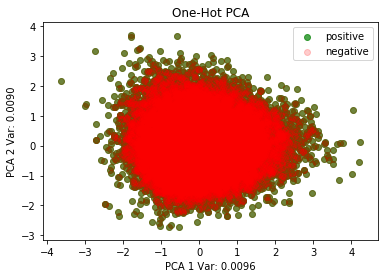

In [54]:
#Creating Visualization
concat_pca = PCA(n_components=2)
concat_pca.fit(concat_concat)
var1 = concat_pca.explained_variance_ratio_[0]
var2 = concat_pca.explained_variance_ratio_[1]
p_coord = concat_pca.transform(p_concat)
n_coord = concat_pca.transform(n_concat)
p_dim1 = p_coord[:, 0]
p_dim2 = p_coord[:, 1]
n_dim1 = n_coord[:, 0]
n_dim2 = n_coord[:, 1]
plt.scatter(p_dim1, p_dim2, color = 'g', alpha=0.7, label = 'positive')
plt.scatter(n_dim1, n_dim2, color = 'r', alpha=0.2, label = 'negative')
plt.title("One-Hot PCA")
plt.xlabel('PCA 1 Var: ' + str(var1)[:6])
plt.ylabel('PCA 2 Var: '+ str(var2)[:6])
plt.legend()
plt.show()

In [76]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from scipy import interp

Text(0.5, 1.0, 'HNF4A Classification ROC')

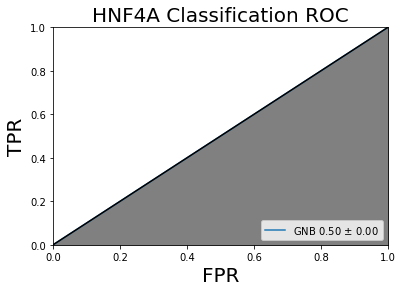

In [78]:
#Defining Data into X and Y
X = np.array(concat_concat)
y = np.array([1]*len(p_concat)+[0]*len(n_concat))
gnb = GaussianNB()
cv = StratifiedKFold(n_splits = 5)
mean_fpr = np.linspace(0, 1, 100)
mean_recall = np.linspace(0, 1, 100)
aucs = []
tprs = []
for train, test in cv.split(X, y):
    gnb.fit(X[train], y[train])
    prob_pos = gnb.predict_proba(X[test])[:, 1]
    fpr, tpr, _ = roc_curve(y[test], prob_pos)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, label='GNB' + r' %0.2f $\pm$ %0.2f' % (mean_auc, std_auc))
plt.plot([0, 1], [0, 1], color='black')
plt.xlim([0.0, 1.0])
plt.ylim([0, 1])
plt.ylabel('TPR', fontsize = 20)
plt.xlabel('FPR', fontsize = 20)
plt.legend(loc = 'lower right')
plt.fill_between(x = [0,1], y1 = [0,1], color = 'gray')
plt.title('HNF4A Classification ROC', fontsize = 20)

Text(0.5, 1.0, 'HNF4A Classification PRC')

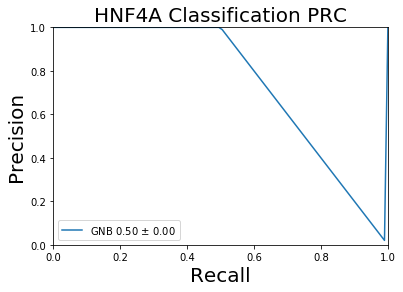

In [79]:
mean_fpr = np.linspace(0, 1, 100)
aucs = []
tprs = []
for train, test in cv.split(X, y):
    gnb.fit(X[train], y[train])
    prob_pos = gnb.predict_proba(X[test])[:, 1]
    fpr, tpr, _ = precision_recall_curve(y[test], prob_pos)
    roc_auc = average_precision_score(y[test], prob_pos)
    aucs.append(roc_auc)
    tprs.append(interp(mean_fpr, fpr, tpr))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, label='GNB' + r' %0.2f $\pm$ %0.2f' % (mean_score, std_auc))
plt.xlim([0.0, 1.0])
plt.ylim([0, 1])
plt.ylabel('Precision', fontsize = 20)
plt.xlabel('Recall', fontsize = 20)
plt.legend(loc = 'lower left')
plt.title('HNF4A Classification PRC', fontsize = 20)

# Regression Prototyping

Regression of HNF4A chromosomes.
We will train on chr19 and test on chr15. These chromosomes were picked due to them containing several important CYP genes. 

In [2]:
# Importing 2bit Genome Object
hg38 = tbr.TwoBitFile("../data/hg38.2bit")

In [6]:
def oheConcatSeq(DNAString):
    """
    Given a Seqence this will turn the string to an array of concatenated One Hots
    for each nucleotide
    """
    seq = DNAString.upper()
    nuc = 'ACGT'
    char2int = dict((c, i) for i, c in enumerate(nuc))
    int2char = dict((i, c) for i, c in enumerate(nuc))
    integer_encoded = [char2int[char] for char in seq]
    OHE = []
    for value in integer_encoded:
        letter = [0 for _ in range(len(nuc))]
        letter[value] = 1
        OHE.extend(letter)
    seq_ohe = np.asarray(OHE)
    return seq_ohe

#Optimizing GenSeq
def bitGenSeq(twoBitGenome, chrom, chromstart, chromend):
    """
    Creates Sequences from basic bed coordinate files using only a 2bit
    gneome.
    Require TwoBitReader Module from python.
    
    twoBitGenome = 2bit Genome file Object
    chrom = chromosome number
    chromstart = starting nucleotide position on chromosome
    chromend = ending nucleotide position on chromosome
    """
    seq = twoBitGenome[chrom][chromstart:chromend]
    return (seq).upper()

In [7]:
#Load BigWig Summary Data for 100 bp bins
names = ['chr', 'start', 'end', 'size', 'num_data', 'min', 'max', 'mean', 'median']
chr15 = pd.read_csv('../data/hnf4a_chr15_regression.txt', sep = '\t', names = names)
chr19 = pd.read_csv('../data/hnf4a_chr19_regression.txt', sep = '\t', names = names)
chr15[:10]

,chr,start,end,size,num_data,min,max,mean,median
0,chr15,0,100,100,100,0.02,0.02,0.02,0.02
1,chr15,100,200,100,100,0.02,0.02,0.02,0.02
2,chr15,200,300,100,100,0.02,0.02,0.02,0.02
3,chr15,300,400,100,100,0.02,0.02,0.02,0.02
4,chr15,400,500,100,100,0.02,0.02,0.02,0.02
5,chr15,500,600,100,100,0.02,0.02,0.02,0.02
6,chr15,600,700,100,100,0.02,0.02,0.02,0.02
7,chr15,700,800,100,100,0.02,0.02,0.02,0.02
8,chr15,800,900,100,100,0.02,0.02,0.02,0.02
9,chr15,900,1000,100,100,0.02,0.02,0.02,0.02


In [53]:
# Import and Transform Training Data
chr19_OHE = []
for i in chr19.values:
    try:
        ohe = oheConcatSeq(bitGenSeq(hg38, 'chr19', i[1], i[2])).tolist()
        ohe.append(i[7])
        chr19_OHE.append(ohe)
    except KeyError:
        continue
ch19_df = pd.DataFrame(chr19_OHE,)
del chr19_OHE

,OHE,Mean
0,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",0.02
1,"[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",0.02
2,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",0.02
3,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...",0.02
4,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...",0.02
5,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, ...",0.02
6,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, ...",0.02
7,"[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",0.02
8,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...",0.02
9,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.02


In [56]:
#Import Regressions
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor

In [57]:
#Code for Validation Curve from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [72]:
#Setting Model Parameters
rfr = RandomForestRegressor(random_state=42, n_estimators = 25, n_jobs=-1)
knr = KNeighborsRegressor(n_neighbors=15, n_jobs=-1)

In [ ]:
# Setting Cross Validation
cv = ShuffleSplit(n_splits=5)
#Setting up X and y
X = ch19_df.iloc[:,:400]
y = ch19_df.iloc[:,-1]

plot_learning_curve(rfr, 'HNF4A Regression: RFR', X, y, cv = cv)

/Users/omarkana/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [64]:
#Create Data Corpus for Classification
hnf4a_seq = [bitGenSeq(hg38, list(i)[0], int(list(i)[1]), int(list(i)[2])) for i in h_complement]
rara_seq = [bitGenSeq(hg38, list(i)[0], int(list(i)[1]), int(list(i)[2])) for i in r_complement]

In [65]:
#Binnig DNA Sequences for peaks
hnf4A_bins = []
for i in hnf4a_seq:
    hnf4A_bins.extend([i[j:j+50] for j in range(0, len(i)-50, 50)])
hnf4A_bins = np.asarray(hnf4A_bins)

rara_bins = []
for i in rara_seq:
    rara_bins.extend([i[j:j+50] for j in range(0, len(i)-50, 50)])
rara_bins = np.asarray(rara_bins)

In [69]:
h_bins = []
r_bins = []
for i in range(len(hnf4A_bins)):
    if "N" in hnf4A_bins[i]:
        continue
    else:
        h_bins.append(hnf4A_bins[i])
for i in range(len(rara_bins)):
    if "N" in rara_bins[i]:
        continue
    else:
        r_bins.append(rara_bins[i])
print(len(h_bins),len(r_bins))

350086 141855


# One Hot Encoding

So we will start with One-Hot Encoding. Here we will encode the sequence using 4 dimensional One-Hots. A One-Hot is a vector of all 0's except for one 1. The position of the 1 is what identifies the nucletide at a specific postion

e.g. 
A = [1,0,0,0] or T = [0,1,0,0]

etc. etc. 

One-Hot Encoding is the simplest encoding. Here we will look at making an average One-Hot, and a concatenated One-Hot on a binary classification problem between RXR and HNF4A. 

Here One-Hot will be done at the nucleotide level. 

In [48]:
def oheSeq(DNAString):
    """
    Given a Seqence this will turn the string to an array of One Hots
    for each nucleotide
    """
    seq = DNAString.upper()
    nuc = 'ACGT'
    char2int = dict((c, i) for i, c in enumerate(nuc))
    int2char = dict((i, c) for i, c in enumerate(nuc))
    integer_encoded = [char2int[char] for char in seq]
    OHE = []
    for value in integer_encoded:
        letter = [0 for _ in range(len(nuc))]
        letter[value] = 1
        OHE.append(letter)
    seq_ohe = np.asarray(OHE)
    return seq_ohe

In [71]:
#Basic array representation
h_ohe = [oheSeq(i) for i in h_bins]
r_ohe = [oheSeq(i) for  i in r_bins]

In [80]:
#Averaged Over 50 bp bin
#4 dim "sentence" vector
h_freq =[]
for i in h_ohe:
    n = len(i)
    freq = [0,0,0,0]
    for j in i:
        freq = np.add(freq, j)
    h_freq.append(freq/n)
r_freq =[]
for i in r_ohe:
    n = len(i)
    freq = [0,0,0,0]
    for j in i:
        freq = np.add(freq, j)
    r_freq.append(freq/n)

In [82]:
#Concatenated OHE representation
#200 dim "sentence" vector
h_concat = []
for i in h_ohe:
    h_concat_i = []
    for j in i:
        h_concat_i.extend(j)
    h_concat.append(h_concat_i)
r_concat = []
for i in r_ohe:
    r_concat_i = []
    for j in i:
        r_concat_i.extend(j)
    r_concat.append(r_concat_i)

In [84]:
#PCA, T-SNE, and UMAP Visualizations
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap 

/Users/omarkana/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [94]:
freq_concat = h_freq + r_freq
concat_concat = h_concat + r_concat

In [95]:
freq_pca = PCA(n_components=2)
concat_pca = PCA(n_components=2)

freq_pca.fit(freq_concat)
concat_pca.fit(concat_concat)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

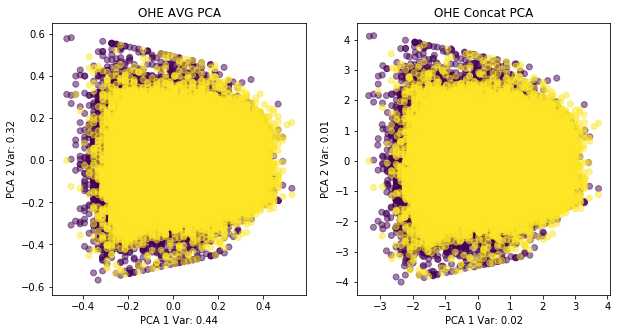

In [96]:
NR = [0]*len(h_freq) + [1]*len(r_freq)
pca_coord = freq_pca.transform(freq_concat)
dim1 = pca_coord[:, 0]
dim2 = pca_coord[:, 1]
fig, ax = plt.subplots(1,2, figsize = [10,5])
ax[0].scatter(dim1, dim2, c = NR, cmap='viridis', alpha=0.5)
ax[0].set_title("OHE AVG PCA")
ax[0].set_xlabel('PCA 1 Var: ' + str(freq_pca.explained_variance_ratio_[0])[:4])
ax[0].set_ylabel('PCA 2 Var: '+ str(freq_pca.explained_variance_ratio_[1])[:4])

NR = [0]*len(h_concat) + [1]*len(r_concat)
pca_coord = concat_pca.transform(concat_concat)
dim1 = pca_coord[:, 0]
dim2 = pca_coord[:, 1]
ax[1].scatter(dim1, dim2, c = NR, cmap='viridis', alpha=0.5)
ax[1].set_title("OHE Concat PCA")
ax[1].set_xlabel('PCA 1 Var: ' + str(concat_pca.explained_variance_ratio_[0])[:4])
ax[1].set_ylabel('PCA 2 Var: '+ str(concat_pca.explained_variance_ratio_[1])[:4])
plt.show()

In [97]:
X_freq = TSNE(n_components=2).fit_transform(freq_concat)
X_concat = TSNE(n_components=2).fit_transform(concat_concat)

KeyboardInterrupt: 

In [ ]:
NR = [0]*len(h_freq) + [1]*len(r_freq)
pca_coord = freq_pca.transform(freq_concat)
dim1 = X_freq[:, 0]
dim2 = X_freq[:, 1]
fig, ax = plt.subplots(1,2, figsize = [10,5])
ax[0].scatter(dim1, dim2, c = NR, cmap='viridis', alpha=0.5)
ax[0].set_title("OHE AVG TSNE")
ax[0].set_xlabel('PCA 1 Var: ' + str(freq_pca.explained_variance_ratio_[0])[:4])
ax[0].set_ylabel('PCA 2 Var: '+ str(freq_pca.explained_variance_ratio_[1])[:4])

NR = [0]*len(h_concat) + [1]*len(r_concat)
pca_coord = concat_pca.transform(concat_concat)
dim1 = X_concat[:, 0]
dim2 = X_Concat[:, 1]
ax[1].scatter(dim1, dim2, c = NR, cmap='viridis', alpha=0.5)
ax[1].set_title("OHE Concat TSNE")
ax[1].set_xlabel('PCA 1 Var: ' + str(concat_pca.explained_variance_ratio_[0])[:4])
ax[1].set_ylabel('PCA 2 Var: '+ str(concat_pca.explained_variance_ratio_[1])[:4])
plt.show()

In [98]:
u_freq = umap.UMAP().fit_transform(freq_concat)
u_concat = umap.UMAP().fit_transform(concat_concat)

/Users/omarkana/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py:439: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /Users/omarkana/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py (446)

File "../../../anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 446:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_euclidean_tree a

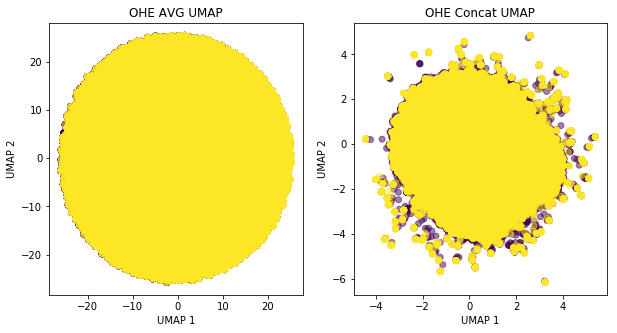

In [102]:
NR = [0]*len(h_freq) + [1]*len(r_freq)
dim1 = u_freq[:, 0]
dim2 = u_freq[:, 1]
fig, ax = plt.subplots(1,2, figsize = [10,5])
ax[0].scatter(dim1, dim2, c = NR, cmap='viridis', alpha=0.5)
ax[0].set_xlabel('UMAP 1')
ax[0].set_ylabel('UMAP 2')
ax[0].set_title("OHE AVG UMAP")

NR = [0]*len(h_concat) + [1]*len(r_concat)
dim1 = u_concat[:, 0]
dim2 = u_concat[:, 1]
ax[1].scatter(dim1, dim2, c = NR, cmap='viridis', alpha=0.5)
ax[1].set_xlabel('UMAP 1')
ax[1].set_ylabel('UMAP 2')
ax[1].set_title("OHE Concat UMAP")
plt.show()

In [92]:
# Make Simple Models of HNF4A and CAR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from scipy import interp

# TF-IDF

In [105]:
# Create a tokenizer for the DNA embedding
# We will take overlapping vectors here. 

def tokenizer(DNAString, k):
    """
    Take a DNA Sequence and create a list of overlapping DNA "words" of length k.
    """
    tokens = [DNAString[i:i+k] for i in range(len(DNAString)-k)]
    return tokens

#test tokenizer
print(h_bins[0])
print(tokenizer(h_bins[0], 6))

GGCTTCAAATTTCAGTAGAAATGACTGTATAGTCTTCATTCAGAGTGTTT
['GGCTTC', 'GCTTCA', 'CTTCAA', 'TTCAAA', 'TCAAAT', 'CAAATT', 'AAATTT', 'AATTTC', 'ATTTCA', 'TTTCAG', 'TTCAGT', 'TCAGTA', 'CAGTAG', 'AGTAGA', 'GTAGAA', 'TAGAAA', 'AGAAAT', 'GAAATG', 'AAATGA', 'AATGAC', 'ATGACT', 'TGACTG', 'GACTGT', 'ACTGTA', 'CTGTAT', 'TGTATA', 'GTATAG', 'TATAGT', 'ATAGTC', 'TAGTCT', 'AGTCTT', 'GTCTTC', 'TCTTCA', 'CTTCAT', 'TTCATT', 'TCATTC', 'CATTCA', 'ATTCAG', 'TTCAGA', 'TCAGAG', 'CAGAGT', 'AGAGTG', 'GAGTGT', 'AGTGTT']


In [107]:
#We will be using 3mers to 8mers for most of the material here. However due to the effectiveness of fastDNA, we were able to get up to 13mers for that particular model.
from collections import Counter
testSeq = h_bins[0]
tokens = tokenizer(testSeq, 3)
bagOfKgrams = Counter(tokens)
print(bagOfKgrams)
print(bagOfKgrams.most_common(3))
uniq_tokens = set(tokens)

Counter({'TTC': 4, 'TCA': 4, 'AGT': 3, 'CTT': 2, 'AAA': 2, 'AAT': 2, 'ATT': 2, 'CAG': 2, 'GTA': 2, 'TAG': 2, 'AGA': 2, 'TGT': 2, 'GGC': 1, 'GCT': 1, 'CAA': 1, 'TTT': 1, 'GAA': 1, 'ATG': 1, 'TGA': 1, 'GAC': 1, 'ACT': 1, 'CTG': 1, 'TAT': 1, 'ATA': 1, 'GTC': 1, 'TCT': 1, 'CAT': 1, 'GAG': 1, 'GTG': 1, 'GTT': 1})
[('TTC', 4), ('TCA', 4), ('AGT', 3)]


In [109]:
from itertools import product
def SeqPermuteVocab(k_low, k_high, letters = 'ATCG'):
    """
    Create All Sequence Permutations from length k_low to k_high.
    The default letters are for standard DNA sequences.
    """
    vocab = []
    for i in range(k_low, k_high+1):
        for seq in product(letters, repeat=i):
            kmer = ''.join(seq)
            vocab.append(kmer)
    return vocab
vocab = SeqPermuteVocab(3,3)
vocab

['AAA',
 'AAT',
 'AAC',
 'AAG',
 'ATA',
 'ATT',
 'ATC',
 'ATG',
 'ACA',
 'ACT',
 'ACC',
 'ACG',
 'AGA',
 'AGT',
 'AGC',
 'AGG',
 'TAA',
 'TAT',
 'TAC',
 'TAG',
 'TTA',
 'TTT',
 'TTC',
 'TTG',
 'TCA',
 'TCT',
 'TCC',
 'TCG',
 'TGA',
 'TGT',
 'TGC',
 'TGG',
 'CAA',
 'CAT',
 'CAC',
 'CAG',
 'CTA',
 'CTT',
 'CTC',
 'CTG',
 'CCA',
 'CCT',
 'CCC',
 'CCG',
 'CGA',
 'CGT',
 'CGC',
 'CGG',
 'GAA',
 'GAT',
 'GAC',
 'GAG',
 'GTA',
 'GTT',
 'GTC',
 'GTG',
 'GCA',
 'GCT',
 'GCC',
 'GCG',
 'GGA',
 'GGT',
 'GGC',
 'GGG']